<a href="https://colab.research.google.com/github/OSGeoLabBp/tutorials/blob/master/hungarian/machine_learning/lessons/o_x_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kézzel írt jelek osztályozása

A következőkben az "o" és "x" jelek felismerésén keresztül mutatjuk be a gépi tanulási módszerek adatelőkészítési és tanitási folyamatát.

Egy kisebb mintát (80 "o" és 80 "x") használunk, melyeket egy A4-es lapra írtunk.

Két módszert, egy gépi tanulási (Scikit Learn) és egy mély tanulási (Keras)eljárást mutatunk be.

## SVM (Support Vector Machine)

### Input adatok előkészítése

Az A4-es lapra írt, táblázatosan elrendezett adatokat fel kell darabolnunk, hogy egy képen csak egy jel legyen, egy kis kép felbontást 32 x 32 pixelre csökkentjük

In [2]:
# Néhány konstans a feldolgozáshoz
image_size = 32                 # a kis képek mérete (négyzetes), pixel
sample_start = 0                # ettől a sortól kell feldolgozni a mintákat
sample_rows = 16                # eddig a sorig kell feldolgozni a mintákat
sample_cols = 10                # ennyi minta van egy sorban
sample_num = sample_rows * sample_cols  # összes minta száma
size = 177                      # markerek szkennelt mérete, pixel
border = 10                     # vágási margó, pixel
margin = 6                      # bal oldali margó
labels = ["circle", "cross"]    # cimke nevek, 0-kör, 1-x)

A feldokgozás során a Scikit Learn könyvtárat használjuk. A következő blokk a szükséges modulokat tölti be.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.filters import threshold_otsu
from skimage.transform import resize
from skimage.morphology import erosion, convex_hull_image
from skimage.util import invert
from sklearn.model_selection import train_test_split

Töltsük le és jelenítsük meg a kiinduló A4-es szkennelt lapot.

In [6]:
!wget -q -O o_x.png https://github.com/OSGeoLabBp/tutorials/blob/master/english/machine_learning/lessons/data/o_x.png?raw=true

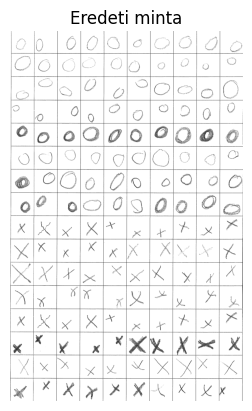

In [7]:
img = imread('o_x.png', as_gray=True)     # kép betöltése szürkeárnyalatosként
#thresh = threshold_otsu(img)
#img = (img > thresh).astype('int8')       # convert binary
plt.axis("off")
plt.imshow(img, cmap='gray')
_ = plt.title("Eredeti minta")

Az előkészítés során az egyes kis mintákat kivágjuk a nagy képből, a vonalak esetleges szakadozását vastagítással megszüntetjük és kétszínű képpé alakítjuk.

In [10]:
# tömbök létrehozása a bemenő adatoknak és a címkéknek
scaling = True                                                # jel terjedelmére nagyítás igen/nem
X = np.zeros((sample_num, image_size, image_size, 1), dtype='float32')
y = np.zeros(sample_num, dtype='float32')
y[sample_num // 2:] = 1              # első fele "o"/0, második fele "x"/1
# az egyes jeleket tartalmazó képek létrehozása
k = 0
for i in range(sample_start, sample_start + sample_rows):     # minden sorra
    pixel_top = i * size + border                             # sor felső pixele
    pixel_bot = (i + 1) * size - border                       # sor alsó pixele
    for j in range(10):                                       # minden oszlopra
        pixel_left = margin + j * size + border               # oszlop bal széle pixel
        pixel_righ = (j + 1) * size - border                  # oszlop jobb széle pixel
        sub_img = erosion(erosion(img[pixel_top:pixel_bot,pixel_left:pixel_righ]))
        thresh = threshold_otsu(sub_img)                      # fekete-fehérré alakítás
        sub_img = (sub_img > thresh).astype('uint8')
        inv = invert(sub_img) - 254
        indx = np.nonzero(inv)
        sub_row0, sub_row1 = np.min(indx[0]), np.max(indx[0]+1) # jel befoglaló idoma
        sub_col0, sub_col1 = np.min(indx[1]), np.max(indx[1]+1)
        if scaling:
            # jel területének a kivétele és a felbontás lecsökkentése
            X[k] = np.expand_dims(resize(sub_img[sub_row0:sub_row1, sub_col0:sub_col1], (image_size, image_size)), -1)
        else:
            # felbontás lecsökkentése
            X[k] = np.expand_dims(resize(sub_img, (image_size, image_size)), -1)
        k += 1

Nézzük meg az egyes jelek képét és a hozzájuk tartozó címkéket!

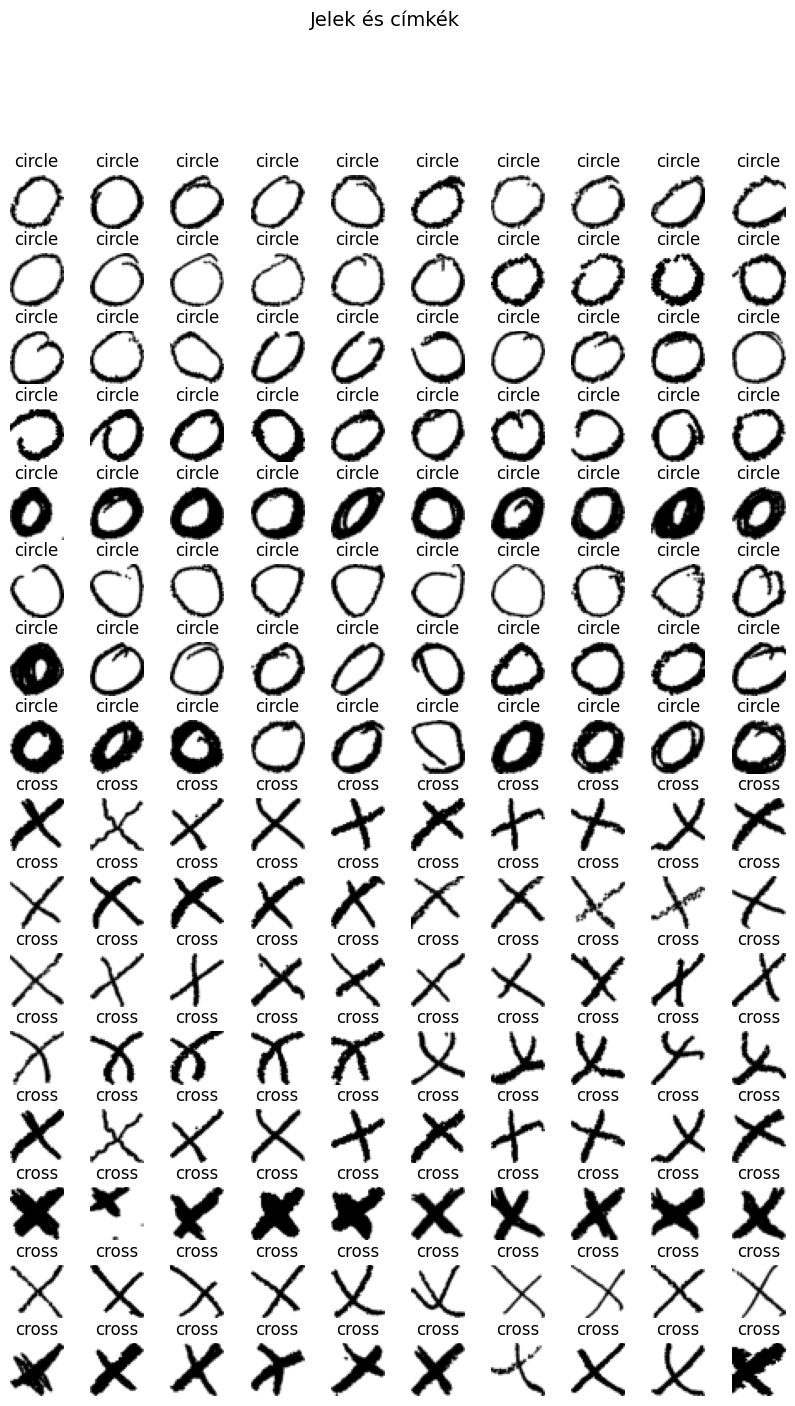

In [11]:
fig, ax = plt.subplots(sample_rows, sample_cols, figsize=(sample_cols, sample_rows))
fig.suptitle('Jelek és címkék', fontsize=14)
ax = ax.ravel()
for i in range(sample_rows * sample_cols):
    ax[i].imshow(X[i], cmap='gray')
    ax[i].set_title(labels[int(y[i])])
    ax[i].axis('off')
plt.subplots_adjust(wspace=0.5)

Bontsuk fel az adatokat tréning (70%) és teszt (30%) adatokra.
A SVM csak vektorokat tud imput adatként kezelni, ezért a image_size x image_size méretű mátrixokkat vektorrá kell átalakítani.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)
XX_train = np.zeros((X_train.shape[0], image_size * image_size), dtype='float32')
XX_test = np.zeros((X_test.shape[0], image_size * image_size), dtype='float32')
for i in range(X_train.shape[0]):
    XX_train[i] = X_train[i].reshape(image_size * image_size)
for i in range(X_test.shape[0]):
    XX_test[i] = X_test[i].reshape(image_size * image_size)

In [16]:
from sklearn import svm
from sklearn import metrics
clf = svm.SVC(C=1000000000.0, gamma=1e-6, kernel="rbf")
clf.fit(XX_train, y_train)
y_test_pred = clf.predict(XX_test)
y_train_pred = clf.predict(XX_train)
print(f"Pontosság (teszt/tréning): {metrics.accuracy_score(y_test, y_test_pred):.1%} / {metrics.accuracy_score(y_train, y_train_pred):.1%}")

Pontosság (teszt/tréning): 100.0% / 100.0%


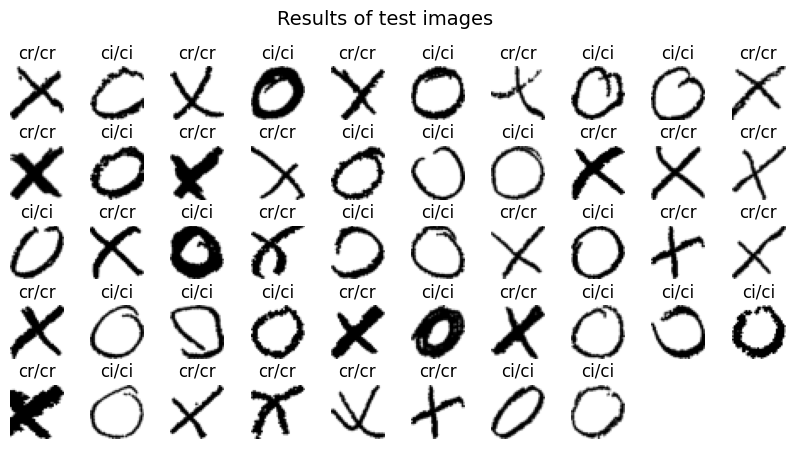

In [18]:
# teszt képek ismert és becsült címkék
fig, ax = plt.subplots(X_test.shape[0]//sample_cols+1, sample_cols, figsize=(sample_cols, X_test.shape[0]//sample_cols+1))
fig.suptitle('Results of test images', fontsize=14)
ax = ax.ravel()
for a in ax:
    a.axis("off")       # turn off axis on all subplots

for i in range(X_test.shape[0]):
    cmap = 'gray' if int(y_test[i]) == int(y_test_pred[i]) else 'Reds'
    ax[i].imshow(X_test[i], cmap=cmap)
    ax[i].set_title(f"{labels[int(y_test[i])][:2]}/{labels[int(y_test_pred[i])][:2]}")
plt.subplots_adjust(wspace=0.5)